In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import matplotlib.ticker as mticker
import time as t

# Defining Constants Used Throughout

In [2]:
### Here we define constants from the QMC model used through

w1   = 0.71       ### Fitting constant for sigma meson (unitless)
w2   = 0.69       ### Fitting constant for sigma meson (unitless)
wom  = 2/3        ### Fitting constant for omega meson (unitless)
d    = 0.176      ### Scalar polarisability constant for effective mass in [fm]
MeV  = 197.3      ### Conversion for [fm^-1] -> [MeV]
ML   = 1115.6     ### Mass of Lambda in [MeV]
k    = 143.996    ### Coulomb constant (MeV.fm.e^-2)
msig = 504/MeV    ### Mass of sigma meson [Unitless here]
    
### Here we define constants for the Woods-saxon potential

aWS  = 0.6        ### W-S Density constant in [fm]
c    = 1.1        ### W-S Constant multiplying A^1/3 term
rho0 = 0.15       ### Nuclear matter density in [fm^-3]

# Defining Binding Potential and Woods-Saxon Density and Derivatives of Density

In [3]:
### Defining the Woods-saxon Potential
def rho(r, A):
    val = rho0/(1+np.exp((r-c*A**(1/3))/aWS))
    return val

### Second derivative of Woods-saxon Potential
def diffrho(r, A):
    exparg = np.exp((r-c*A**(1/3))/aWS)
    val = rho0*(-2*aWS*(1+exparg)-r*(1-exparg))*exparg/(aWS**2*r*(1+exparg)**3)
    return val

def diff2rho(r,A):
    exparg = np.exp((r-c*A**(1/3))/aWS)
    val = 2*rho0**2*(-2*aWS*(exparg+1)-r*(1-exparg))*exparg/(aWS**2*r*(1+exparg)**4)
    return val

def diffrhosquare(r,A):
    exparg = np.exp((r-c*A**(1/3))/aWS)
    val = -2*rho0*exparg/(aWS*(1+exparg)**3)
    return val

In [4]:
### Defining the many-body potential

def V(r, A, Gsig, Gom, l):
    ### Coefficients for the many-body forces, in MeV
    
    c1   = -w1*Gsig*MeV + wom*Gom*MeV        ### 2-Body Forces
    c2   =  (d*w1+d*w2/2)*Gsig**2*MeV        ### 3-Body Forces
    c3   = -(d**2*w1+d**2*w2)*Gsig**3*MeV    ### 4-Body Forces
    
    ### Derivative terms
    drho_drho  =  -d*Gsig**2*(w1+w2)*diffrho(r, A)**2/msig**2*MeV
    drho2_drho =   Gsig**3*d**2*(w1+w2)*diffrho(r,A)*diffrhosquare(r,A)/msig**2*MeV
    d2rho      =   Gsig**3*d**2*(w1+2*w2)*rho(r,A)*diff2rho(r,A)/msig**2*MeV
    
    ### Definining a term that accounts for the velocity-dependent terms from the equations of motion
    Inverse = 1+Gsig*rho(r,A)*w1*MeV/ML-Gsig**2*rho(r,A)**2*d*(w1+w2/2)*MeV/ML+Gsig**3*rho(r,A)**3*d**2*(w1+w2)*MeV/ML
    Inverse_drho = (w2*d*Gsig**2*diffrho(r,A)**2-Gsig**3*d**2*w2*diffrho(r,A)*diffrhosquare(r,A)-d2rho*msig**2/MeV)*MeV/(ML*msig**2)
    
    
    ### Defining the Angular Momentum term
    if l==0:
        Ang = 0
    else:
        Ang  =  l*(l+1)/(2*ML*r**2)*MeV**2
    
    ### Returning the Binding Potential
    result = (c1*rho(r,A)+c2*rho(r,A)**2+c3*rho(r,A)**3+drho_drho+drho2_drho+d2rho)/(Inverse+Inverse_drho)+Ang
    
    return result

## Second form for the Potential

The velocity dependent term also modifies the energy eigenvalue, and thus I had to include a second function for inputting into the Numerov Algorithm which accounts for this. We have here:
$\frac{(E-V(r))}{\text{Velocity-dependent terms}}$

And we note that from rearranging the Hamiltonian from the EoM that the angular momentum term is unaffected by the velocity-dependence, so we simply add it to the other term involved.

In [5]:
def VTwo(r, A, E, Gsig, Gom, l):
    ### Coefficients for the many-body forces, in MeV
    
    c1   = -w1*Gsig*MeV + wom*Gom*MeV        ### 2-Body Forces
    c2   =  (d*w1+d*w2/2)*Gsig**2*MeV        ### 3-Body Forces
    c3   = -(d**2*w1+d**2*w2)*Gsig**3*MeV    ### 4-Body Forces
    
    ### Derivative terms
    drho_drho  =  -d*Gsig**2*(w1+w2)*diffrho(r, A)**2/msig**2*MeV
    drho2_drho =   Gsig**3*d**2*(w1+w2)*diffrho(r,A)*diffrhosquare(r,A)/msig**2*MeV
    d2rho      =   Gsig**3*d**2*(w1+2*w2)*rho(r,A)*diff2rho(r,A)/msig**2*MeV
    
    ### Definining a term that accounts for the velocity-dependent terms from the equations of motion
    Inverse = 1+Gsig*rho(r,A)*w1*MeV/ML-Gsig**2*rho(r,A)**2*d*(w1+w2/2)*MeV/ML+Gsig**3*rho(r,A)**3*d**2*(w1+w2)*MeV/ML
    Inverse_drho = (w2*d*Gsig**2*diffrho(r,A)**2-Gsig**3*d**2*w2*diffrho(r,A)*diffrhosquare(r,A)-d2rho*msig**2/MeV)*MeV/(ML*msig**2)
    
    
    ### Defining the Angular Momentum term
    if l==0:
        Ang = 0
    else:
        Ang  =  l*(l+1)/(2*ML*r**2)*MeV**2
    
    ### Returning the Binding Potential
    result = -Ang+(E-(c1*rho(r,A)+c2*rho(r,A)**2+c3*rho(r,A)**3+drho_drho+drho2_drho+d2rho))/(Inverse+Inverse_drho)  
    
    return result    

## Defining Classical Turning Point Function

Now we will define some functions which will help to find solutions. We have one function which finds the classical turning point, which is the point where $E-V(r)$, changes sign. When solving using the numerov algorithm we will solve from either side, and match the solutions at the matchpoint which will be this classical turning point.

In [6]:
### Function to find the classical turning point of the potential

def ClassicalTurningPoint(x, N, A, E, Gsig, Gom, l):
    imatch=0
    VVec = VTwo(x, A, E, Gsig, Gom, l)  ### Creating a vector with the values for the potential
    
    ### Looping through the potential looking to find a turning point
    for j in range(N-1):
        CheckPoint = VVec[j]*VVec[j+1]
        if CheckPoint<=0  and VVec[j] > 0:  #match point
            imatch = j+1
    return imatch

# Implementing The Numerov Algorithm

The numerov algorithm is used to solve equations of the form:
$\frac{d^2 y}{dx^2} = f(x)y(x)$.

When applying this to solve the schrodinger in this situation, the equation we have is in the form:

$\frac{d^2\psi}{dr^2} = -2M_\Lambda \left[ \frac{1}{\eta(r)}[E - V_{binding}(r)] -\frac{l(l+1)}{2M_\Lambda r^2} \right]\psi(r)$, which is in the form $\frac{d^2 \psi}{dr^2} = f(r)y(r)$

Where here, $\eta(r)$ is the velocity dependent term, which has the form: $\eta(r) = \left[1+ \frac{1}{M_\Lambda}G_\sigma w \rho_N  - \frac{1}{M_\Lambda}\left( w+\frac{\tilde{w}}{2}\right) dG_\sigma^2 \rho_N^2  +\frac{1}{M_\Lambda}\left( w +  \tilde{w} \right)  d^2G_\sigma^3 \rho^3_N \right]$.

$V_{binding}(r)$ is the binding potential, which has the form: $V_{binding} = -G_\sigma w \rho_N(r) +w_\omega G_\omega  \rho_N(r) + \left( w+\frac{\tilde{w}}{2}\right) dG_\sigma^2 \rho_N^2(r)  -\left( w +  \tilde{w} \right)  d^2G_\sigma^3 \rho^3_N(r) $.

And the final term is the term containing the angular momentum dependence.

We note then that calling the function VTwo in the code is calling $f(r)$, as in the algorithm above, up to a factor of $2M_\Lambda$, which is instead included in the numerov solver below.

In [7]:
### Code to find the solution from the left of the matchpoint

def NumerovLeft(x, psi0, psi1, A, E, h, Gsig, Gom, l, imatch):
    
    ### Defining a vector with all the values for the potential for a given test solution
    VVec = VTwo(x, A, E, Gsig, Gom, l)
    
    ### The term including the step size in the numerov algorithm
    ### Not for our solution here this term includes the mass of the Lambda
    mh12 = ML*h**2/(6*MeV**2)
    
    ### Initialising a vector of zeros with the length of the left-side solution
    PsiL = np.zeros(imatch)
    
    ### Inputting the inital conditions for the solution
    PsiL[0] = psi0
    PsiL[1] = psi1
    
    ### Iterating to find the left-side solution
    for i in range(2, imatch):
        w2 = 1+mh12*(VVec[i])
        w1 = 2*(1-(5*mh12)*(VVec[i-1]))*PsiL[i-1]
        w0 = (1+mh12*(VVec[i-2]))*PsiL[i-2]
        
        ### Filling out the vector with all the calculated values from the numerov algorithm
        PsiL[i] = (w1-w0)/w2
    
    
    return PsiL


### Code to find the solution for the right side of the matchpoint

def NumerovRight(x, psiN, psiNm1, A, E, h, Gsig, Gom, l, imatch):
    
    ### Defining a vector with all the values for the potential for a given test solution
    VVec = VTwo(x, A, E, Gsig, Gom, l)
    
    ### The term including the step size in the numerov algorithm
    ### Not for our solution here this term includes the mass of the Lambda
    mh12 = ML*h**2/(6*MeV**2)
    
    ### Defining the length of the right-side solution
    dim = N-imatch
    
    ### Initialising a vector of zeros with the length of the right-side solution
    PsiR    = np.zeros(dim)
    
    ### Inputting the initial conditions for the right-side solution
    PsiR[0] = psiN
    PsiR[1] = psiNm1
    
    ### Iterating to find the solutions for the right-side
    for i in range(2, dim):
        w2 = 1+mh12*(VVec[i])
        w1 = 2*(1-(5*mh12)*(VVec[i-1]))*PsiR[i-1]
        w0 = (1+mh12*(VVec[i-2]))*PsiR[i-2]
        
        ### Filling out the vector with all the calculated values from the numerov algorithm
        PsiR[i] = (w1-w0)/w2
    
    ### We have at this stage the solution back to front for a right-side solution.
    ### This is because of the way we arranged the loop
    ### So we now flip the solution around to find the right-side solution properly
    PsiR = np.flip(PsiR)
    
    return PsiR

# Defining a Function to find Energy Eigenstate

We now have functions to calculate the wavefunction for a given energy, so we now need to put this together to find a valid energy eigenstate. This process works by:

1. We make an initial guess for what the energy should be

2. Solve for the wavefunction for the given energy using the numerov algorithm. We solve the equation by finding the classical energy turning point, and integrating from the left to the match point, and indenpendently from the right to the match point. This allows for us to test whether the energy is a valid energy eigenstate, and also helps to minimise numerical errors.

3. We then enforce continuity by scaling the left side solution to match that at the right side

4. After normalising the wavefunction we can test for smoothness. If the wavefunction is smooth we have found a valid energy eigenstate. If it is not then we increment the energy by an amount dE until we find a valid solution.

5. Once we have a valid solution it is possible that there would be some uncertainty in the exact value for the energy, so we continue to increment by dE and test for a solution. Once the solution is no longer valid for a given energy we have found an upper and lower bound for the energy eigenstate.


In [8]:
def Find_Energy(x, A, Ein, dE, Gsig, Gom, l, psi0, psi1, psiNm1, psiN, maxit, eps):
    
    ### We begin by initialising a number of constants. 
    E     = Ein              ### Setting the energy to the initial energy
    Psi   = np.zeros(N)      ### Initialising a vector of zeros for our solution
    check = 0                ### Defining a counter to let us find the upper and lower bounds for the energy.
    Eerr  = 0                ### Defining the error in the energy
    dE    = np.abs(dE)       ### Ensuring the step size for the energy is positive
    
    ### We begin iterating over energy values until we find a valid solution
    
    for i in range(maxit):
        
        ### We first find the solutions to the Schrodinger equation for a given energy
        ### This is done using the above numerov algorithm.
        matchP = ClassicalTurningPoint(x, N, A, E, Gsig, Gom, l)
        PsiL = NumerovLeft(x, psi0, psi1, A, E, h, Gsig, Gom, l, matchP)
        PsiR = NumerovRight(x, psiN, psiNm1, A, E, h, Gsig, Gom, l, matchP)
        
        
        ### Now we wish for our solution to be continuous
        ### We can enforce this by scaling one side of the solution by the other
        PsiLmatch = PsiL[matchP-1]
        PsiRmatch = PsiR[0]
        scale     = PsiRmatch/PsiLmatch
        PsiL      = scale*PsiL
        
        
        ### Following this we shall combine the left and right side solutions to one solution and then normalise it
        Psi     = np.concatenate((PsiL, PsiR), axis=None)
        
        ### A simpson integration routine is used to find the normalisation 
        Norm    = integrate.simpson(4*np.pi*Psi*Psi, x)
        PsiNorm = Psi/np.sqrt(Norm)
        
        ### To determine if the solution is valid we test for the smoothness of the functions.
        
        PsiLmm1 = PsiL[matchP-2]
        PsiRmp1 = PsiR[1]
        
        ### Defining an approximatin for the first derivative
        diff = np.abs(PsiLmm1+PsiRmp1-2*PsiRmatch)/(np.sqrt(Norm)*h)
        
        
        ### First we would have found the lower bound for the energy 
        ### This is because we add to the energy inputted (which has a negative value)
        ### So we check if we find the lower bound, then shift to find the upper
        if diff<eps and check==0:
            ### Set the lower bound for the energy
            Elow  = E
            E     = E+dE
            Eup   = E
            ### Setting the check to 1, so the program knows we are searching for the upper bound
            check = 1
            
       
        ### Now we continue iterating to find the upper bound
        elif diff<eps and check==1:
            Eup = E
            E   = E+dE
        
        ### Now once we find a solution where the derivative is greater than the allowed error
        ### we calculate the mean energy and the uncertainity in the energy.
        elif diff>eps and check==1:
            E = (Eup+Elow)/2            ### Return the Mean energy
            Eerr = np.abs((Eup-Elow)/2) ### And return the uncertainty in the energy
            
            ### We break out of the loop once the energy has been found
            break
       
        ### This step is for iterating before we have found the lower bound
        else:
            E = E+dE
        
    return E, Eerr

# Function to find Energy Eigenstates of multiple Nuclei

We now want to find the $\chi^2$ error for a given set of nuclei. To do this we begin with a vector containing the different nuclei we wish to test for and their corresponding experimental values, then:

1. Take an initial energy, as an input to the function, for the first nucleus, and then solve for the energy for the 1s state.
2. Find the $\chi^2$ error for this nucleus, and add this to the total $\chi^2$
3. Set the new input energy as the upper bound for the energy, plus an increment dE
4. Continue to solve for the energy in all the other 1s states. Note it is important that the nucleon number is in descending order for AsVec and ApVec. This ensures that the ground state is found and not higher energy states for example.
5. Set the energy input back to the energy found for the first nucleus, plus a little increment, to solve for the 1p states, repeating steps 2-4 for the 1p states

Throughout this process, if the $\chi^2$ error is ever greater than that of a previous pair of coupling constants then the code breaks, and returns an input for skip, which allows us to cut down on computation time by not spending time solving for pairs of coupling constants that are obviously worse than the current best fit.

In [9]:
def Find_Energies(x, AsVec, ApVec, ExpEs, ExpEp, CurrentChi2, Ein, dE, Gsig, Gom, psi0, psi1, psiNm1, psiN, maxit, eps):
    
    ### We first find the lengths of the vectors
    NsVec = np.size(AsVec)
    NpVec = np.size(ApVec)
    
    ### Initialise vectors for storing the energy eigenvalues and the uncertainity in them
    EVec      = np.zeros(NsVec+NpVec)
    EerrVec   = np.zeros(NsVec+NpVec)
    
    ### Initialising the Chi2Error and Skip Condition
    Chi2Error = 0
    ### Skip condition lets us skip if a solution is going to give us a bigger chi2error than a previous solution
    Skip      = 0
    
    
    ### Solving Energy eigenvalues for 1s states
    
    l=0
    
    for i in range(NsVec):   
        ### Solving for the energy of the i'th 1s nucleus
        EVec[i], EerrVec[i] = Find_Energy(x, AsVec[i], Ein, dE, Gsig, Gom, l, psi0, psi1, psiNm1, psiN, maxit, eps)
        
        ### Adding the Chi2Error for the given solution
        Chi2Error           = Chi2Error + (-EVec[i]-ExpEs[i])**2/ExpEs[i]
        
        ### Setting the new energy for the next iteration
        Ein                 = EVec[i]+EerrVec[i]+np.abs(dE)
        
        ### If the error for the current solution is greater than that of a previous 
        ### we skip finding the rest of the solution
        if Chi2Error>CurrentChi2 and CurrentChi2!=0:
            Skip = 1
            return EVec, EerrVec, Chi2Error, Skip
    
    ### Solving Energy Eigenvalues for 1p states
    
    l=1
    ### Finding the new energy in, which we know should be a little less than the 1s state
    Ein = EVec[0] + 15*dE
    

    for j in range(NpVec):
        ### Solving for the energy of the j'th 1p nucleus 
        EVec[NsVec+j], EerrVec[NsVec+j] = Find_Energy(x, ApVec[j], Ein, dE, Gsig, Gom, l, psi0, psi1, psiNm1, psiN, maxit, eps)
        
        ### Adding to the Chi2Error as in the 1s case
        Chi2Error                       = Chi2Error + (-EVec[NsVec+j]-ExpEp[j])**2/ExpEp[j]
        Ein                             = EVec[NsVec+j]+EerrVec[NsVec+j]+np.abs(dE)
        
        ### Skipping condition again
        if Chi2Error>CurrentChi2 and CurrentChi2!=0:
            Skip = 1
            return EVec, EerrVec, Chi2Error, Skip
        
    
    return EVec, EerrVec, Chi2Error, Skip

# Code to find the Best Fit for the Coupling Constants

We can now turn to finding a best fit for the $G_\omega$ and $G_\sigma$ coupling constants. This is accomplished by:

1. Making an initial guess for the energy by finding the minimum of the binding potential for a given combination for the given set of coupling constants.

2. Checking if the minimum exceeds the maximum or minimum potential depth values. If it does we skip this set of coupling constants, which we set around the expected binding energy for the largest nucleus. (This is optional, but speeds up the code by removing certain combinations that are unlikely to be close to the binding energy).

3. Calculating the error for the given coupling constants. 

4. If the error was significantly larger than the previous best fit, the code will output if the computation wasn't completed for this set of coupling constants. Otherwise if it is better than the current best fit it will update the best fit values.

5. Repeat 1-4 while looping through all combinations of coupling constants desired, and finding the best fit from these. After this is completed the code returns the best fit constants as well as the energies and $\chi^2$ error for this combination.

In [10]:
def BestFit(GsigVec, GomVec, ExpEs, ExpEp, x, AsVec, ApVec, dE, Vmin, Vmax, psi0, psi1, psiNm1, psiN, maxit, eps):
    
    ### Defining length of the coupling constant vectors we test over
    LenSig = np.size(GsigVec)
    LenOm  = np.size(GomVec)
    
    ### Setting chi2error initailly to zero
    OldErr = 0
    
    ### Looping over the coupling constants to be tested
    for i in range(LenOm):        
        for j in range(LenSig):
            l=0
            
            ### Finding the initial energy needed to find a classical turning point
            Ein = np.amin(V(x, AsVec[0], GsigVec[j], GomVec[i], l)) + dE
            
            ### Option to skip certain solutions if the potential depth is outside of a desired range
            if Ein>Vmin and Ein<Vmax:
                
                ### Finding the energies for a particular set of coupling constants
                EGuess, EerrVec, Chi2Error, Skip\
                = Find_Energies(x, AsVec, ApVec, ExpEs, ExpEp, OldErr, Ein, dE, GsigVec[j], GomVec[i],\
                                psi0, psi1, psiNm1, psiN, maxit, eps)
                
                ### If a soltution was found for all the nuclei to be tested, then the results are recorded
                if Skip==0:
                    
                    ### Code for the first time a solution is found
                    if OldErr==0:
                        OldErr    = Chi2Error
                        GomBest   = GomVec[i]
                        GsigBest  = GsigVec[j]
                        EBest     = EGuess
                        EerrBest  = EerrVec
                        print('Initial Error is:', OldErr)
                        print()
                    
                    ### Code for when a better fit is found than the initial fit
                    elif Chi2Error<OldErr:
                        print('Error Changed')
                        print('New Error is:', Chi2Error)
                        print()
                        OldErr    = Chi2Error
                        GomBest   = GomVec[i]
                        GsigBest  = GsigVec[j]
                        EBest     = EGuess
                        EerrBest  = EerrVec
                    
                    ### Alternative output, for when the error is close to the previous best fit  
                    else:
                        print('Error for Gsig:', GsigVec[j], 'and Gom:', GomVec[i], 'is', Chi2Error)
                        print()
                
                ### Code for when the error was greater than the current best fit
                else:
                    print('Error for Gsig:', GsigVec[j], 'and Gom:', GomVec[i], 'is Greater than Current Best Fit')
                    print()

            ### Code for when a set of coupling constants are skipped due to being outside the desired 
            ### potential depth range
            else:
                print('Skipping for Gsig:', GsigVec[j], 'and Gom:', GomVec[i])
                if Ein>Vmin:
                    print('Energy is Lesser than the Minimum')
                    print()
                else:
                    print('Energy is Greater that the Maximum')
                    print()
                    
    ### Setting the Chi2error after finishing iterating over all the possible combinations of coupling constants
    Error = OldErr
    
    return GsigBest, GomBest, Error, EBest, EerrBest

# Defining the Constants used in the Solutions

In [11]:
###Defining the grid spacing

N = 3000                      ### Number of points used
L = 40                        ### Distance to integrate out to
h = L/N                       ### Grid spacing
x = np.linspace(1e-3, L, N)   ### Vector filled with points for distance

### Defining Function Parameters for Numerov Algorithm

dE  = 0.01       ### Energy stepsize
eps = 1e-3       ### Error tolerance for whether a solution has been found
maxit = 10000    ### Number of iterations for energy values that would be carried out

#Boundary Conditions
psi0 = 0
psi1 = 0.1
psiN = 0.001
psiNm1 = 0.005

### Defining the potential depth bounds for whether or not a coupling constant is to be tested

Vmin = -40
Vmax = -20

### Defining the Nucleon numbers for nuclei tested.

APb = 208  ### Lead
ALa = 139  ### Lanthanum
AY  = 89   ### Yttritium
AV  = 51   ### Vanadium
ACa = 40   ### Calcium
AS  = 32   ### Sulfur

### Defining a vector containing the nucleon numbers
AVec1s   = [APb, ALa, AY, AV, ACa, AS]
AVec1p   = [APb, ALa, AY, AV, ACa, AS]


### Experimental Binding Energies Data from Gal, Hungerford & Milliner (2016), Tamura (2006), 
### and Pal, Ghosh et al. (2017)

### 1s States
ExPb1s = 26.5   ### Lead
ExLa1s = 23.8   ### Lanthanum
ExY1s  = 22.1   ### Yttritium
ExV1s  = 19.9   ### Vanadium
ExCa1s = 18.44  ### Calcium
ExS1s  = 17.5   ### Sulfur


### 1p States
ExPb1p = 22.5   ### Lead
ExLa1p = 21.0   ### Lanthanum
ExY1p  = 17.7   ### Yttritium
ExV1p  = 13.46  ### Vanadium
ExCa1p = 11.0   ### Calcium
ExS1p  = 8.2    ### Sulfur


### Defining a vector with the experimental values
ExperimentEnergy1s = [ExPb1s, ExLa1s, ExY1s, ExV1s, ExCa1s, ExS1s]
ExperimentEnergy1p = [ExPb1p, ExLa1p, ExY1p, ExV1p, ExCa1p, ExS1p]

### Coupling Constants to be tested over
GsigVec = np.linspace(8.65 , 10.6, 196)
GomVec  = np.linspace(4.7, 5.73, 104)

## Calling the Function

In [12]:
GsigBest, GomBest, Err, BindingVec, BindingErr = BestFit(GsigVec, GomVec, ExperimentEnergy1s, ExperimentEnergy1p, x, AVec1s, AVec1p, dE, Vmin, Vmax, psi0, psi1, psiNm1, psiN, maxit, eps)

Skipping for Gsig: 8.65 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.66 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.67 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.68 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.69 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.700000000000001 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.71 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.72 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.73 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.74 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.75 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.76 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.77 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 8.780000000000001 a

Skipping for Gsig: 10.18 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 10.19 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 10.2 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 10.209999999999999 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 10.219999999999999 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 10.23 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 10.24 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 10.25 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 10.26 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 10.27 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 10.28 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 10.29 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for Gsig: 10.3 and Gom: 4.7
Energy is Greater that the Maximum

Skipping for G

Skipping for Gsig: 10.59 and Gom: 4.71
Energy is Greater that the Maximum

Skipping for Gsig: 10.6 and Gom: 4.71
Energy is Greater that the Maximum

Skipping for Gsig: 8.65 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 8.66 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 8.67 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 8.68 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 8.69 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 8.700000000000001 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 8.71 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 8.72 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 8.73 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 8.74 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 8.75 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 8.76 

Skipping for Gsig: 10.5 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 10.51 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 10.52 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 10.53 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 10.54 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 10.55 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 10.56 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 10.57 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 10.58 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 10.59 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 10.6 and Gom: 4.72
Energy is Greater that the Maximum

Skipping for Gsig: 8.65 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 8.66 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 8.67 and G

Skipping for Gsig: 10.29 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 10.3 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 10.31 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 10.32 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 10.33 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 10.34 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 10.35 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 10.36 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 10.37 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 10.379999999999999 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 10.39 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 10.4 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for Gsig: 10.41 and Gom: 4.73
Energy is Greater that the Maximum

Skipping for G

Skipping for Gsig: 10.02 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for Gsig: 10.03 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for Gsig: 10.04 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for Gsig: 10.05 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for Gsig: 10.06 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for Gsig: 10.07 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for Gsig: 10.08 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for Gsig: 10.09 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for Gsig: 10.1 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for Gsig: 10.11 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for Gsig: 10.12 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for Gsig: 10.129999999999999 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for Gsig: 10.14 and Gom: 4.74
Energy is Greater that the Maximum

Skipping for 

Skipping for Gsig: 9.81 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.82 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.83 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.84 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.85 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.86 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.87 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.879999999999999 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.89 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.9 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.91 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.92 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.93 and Gom: 4.75
Energy is Greater that the Maximum

Skipping for Gsig: 9.94 an

Skipping for Gsig: 9.59 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.6 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.61 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.62 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.63 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.64 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.65 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.66 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.67 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.68 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.69 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.7 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.71 and Gom: 4.76
Energy is Greater that the Maximum

Skipping for Gsig: 9.72 and Gom: 4.76
En

Skipping for Gsig: 9.41 and Gom: 4.7700000000000005
Energy is Greater that the Maximum

Skipping for Gsig: 9.42 and Gom: 4.7700000000000005
Energy is Greater that the Maximum

Skipping for Gsig: 9.43 and Gom: 4.7700000000000005
Energy is Greater that the Maximum

Skipping for Gsig: 9.44 and Gom: 4.7700000000000005
Energy is Greater that the Maximum

Skipping for Gsig: 9.45 and Gom: 4.7700000000000005
Energy is Greater that the Maximum

Skipping for Gsig: 9.46 and Gom: 4.7700000000000005
Energy is Greater that the Maximum

Skipping for Gsig: 9.47 and Gom: 4.7700000000000005
Energy is Greater that the Maximum

Skipping for Gsig: 9.48 and Gom: 4.7700000000000005
Energy is Greater that the Maximum

Skipping for Gsig: 9.49 and Gom: 4.7700000000000005
Energy is Greater that the Maximum

Skipping for Gsig: 9.5 and Gom: 4.7700000000000005
Energy is Greater that the Maximum

Skipping for Gsig: 9.51 and Gom: 4.7700000000000005
Energy is Greater that the Maximum

Skipping for Gsig: 9.52 and Gom: 

Skipping for Gsig: 9.22 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.23 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.24 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.25 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.26 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.27 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.28 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.290000000000001 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.3 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.31 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.32 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.33 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.34 and Gom: 4.78
Energy is Greater that the Maximum

Skipping for Gsig: 9.35 an

Initial Error is: 127.98775959216206

Error for Gsig: 8.66 and Gom: 4.79 is Greater than Current Best Fit

Skipping for Gsig: 8.67 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 8.68 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 8.69 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 8.700000000000001 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 8.71 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 8.72 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 8.73 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 8.74 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 8.75 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 8.76 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 8.77 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 8.780000000000001 and Gom: 4.79
Energy is Great

Skipping for Gsig: 10.34 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 10.35 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 10.36 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 10.37 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 10.379999999999999 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 10.39 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 10.4 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 10.41 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 10.42 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 10.43 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 10.44 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 10.45 and Gom: 4.79
Energy is Greater that the Maximum

Skipping for Gsig: 10.459999999999999 and Gom: 4.79
Energy is Greater that the Maximum



Skipping for Gsig: 10.26 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.27 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.28 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.29 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.3 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.31 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.32 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.33 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.34 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.35 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.36 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.37 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.379999999999999 and Gom: 4.8
Energy is Greater that the Maximum

Skipping for Gsig: 10.39 a

KeyboardInterrupt: 

## Function which will return results from the best fit

In [ ]:
def ReturnResults(AsVec, ApVec, BindingVec, ExperimentEnergy1s, x, GsigBest, GomBest, Err):
    
    ### Printing what the best fit coupling constants are and the error for these.
    print()
    print('Best fit for Gsig:', GsigBest, 'Best fit for Gom', GomBest, 'Which has a chi^2 of:', Err)
    print()
    
    ### Plotting against A
    End = np.size(AsVec)
    
    
    plt.plot(AsVec, -BindingVec[0:6], label = '1s - Calculated Values')
    plt.plot(AsVec, ExperimentEnergy1s, 'o', label = '1s - Experimental Values')
    plt.plot(ApVec, -BindingVec[6:12], label = '1p - Calculated Values')
    plt.plot(ApVec, ExperimentEnergy1p, 'o', label = '1p- Experimental Values')
    plt.ylim(0, 28)
    plt.xscale('log')
    
    ### Formatting the axes
    ax = plt.gca()

    ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    
    ### Labels and Title
    plt.xlabel('$A$')
    plt.ylabel('Binding Energy [MeV]')
    plt.ylabel('Binding Energy [MeV]')
    plt.legend()
    plt.grid()
    plt.title('Binding Energies against A - 4-Body')

In [ ]:
### Calling the Function
ReturnResults(AVec1s, AVec1p, BindingVec, ExperimentEnergy1s, x, GsigBest, GomBest, Err)

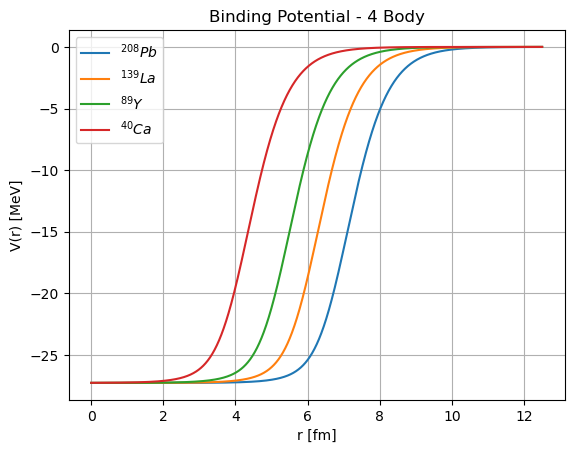

In [52]:
x = np.linspace(0, 12.5, 2000)
plt.plot(x, V(x, APb, GsigBest, GomBest, 0), label = '$^{208}Pb$')
plt.plot(x, V(x, ALa, GsigBest, GomBest, 0), label = '$^{139}La$')
plt.plot(x, V(x, AY, GsigBest, GomBest, 0), label = '$^{89}Y$')
plt.plot(x, V(x, ACa, GsigBest, GomBest, 0),label = '$^{40}Ca$')
plt.grid()
plt.legend()
plt.xlabel('r [fm]')
plt.ylabel('V(r) [MeV]')
plt.title('Binding Potential - 4 Body')